### Problem Statement

The e-commerce business is quite popular today. Here, you do not need to take orders by going to each customer. A company launches its website to sell the items to the end consumer, and customers can order the products that they require from the same website. Famous examples of such e-commerce companies are Amazon, Flipkart, Myntra, Paytm and Snapdeal.

Suppose you are working as a Machine Learning Engineer in an e-commerce company named 'Ebuss'. Ebuss has captured a huge market share in many fields, and it sells the products in various categories such as household essentials, books, personal care products, medicines, cosmetic items, beauty products, electrical appliances, kitchen and dining products and health care products.

With the advancement in technology, it is imperative for Ebuss to grow quickly in the e-commerce market to become a major leader in the market because it has to compete with the likes of Amazon, Flipkart, etc., which are already market leaders.

As a senior ML Engineer, you are asked to build a model that will improve the recommendations given to the users given their past reviews and ratings.

In order to do this, you planned to build a sentiment-based product recommendation system, which includes the following tasks.

Data sourcing and sentiment analysis
Building a recommendation system
Improving the recommendations using the sentiment analysis model
Deploying the end-to-end project with a user interface
Steps involved in the project

Exploratory data analysis
Data cleaning
Text preprocessing
Feature extraction
Training the text classification model
Creating a recommedation systems (User based and Item Based choose the bestone)
Evaluating the model and recommedation system using the Test data
Create flask application
Deploy the application to heroku platform

---


## Imports

In [1]:
# Import all the required libraries

from pathlib import Path
import re
import json
import string
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from nltk.sentiment.util import mark_negation

import joblib

from scipy.sparse import csr_matrix

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity


## Phase 0 — Load Data

In [2]:
# ============================================================
# Phase 0 — Load Data
# Why: Centralize paths, load with encoding fallbacks, and preview.
# ============================================================

# Paths (edit only if your filenames differ)
BASE_DATA = Path("../data")
RAW_DIR   = BASE_DATA / "raw"
RAW_REVIEWS = RAW_DIR / "Product Reviews Dataset.csv"                  # or "Product Dataset.csv"
RAW_ATTRS   = RAW_DIR / "Product Reviews Dataset- Attribute Description.csv"  # or "Product Dataset - Attributes.csv"

def safe_read_csv(path: Path):
    """Try common encodings. Return df, encoding, errors."""
    tried = []
    for enc in ("utf-8", "utf-8-sig", "latin-1"):
        try:
            df = pd.read_csv(path, encoding=enc)
            return df, enc, None
        except Exception as e:
            tried.append((enc, str(e)))
    return None, None, tried

reviews_df, enc_reviews, err_reviews = safe_read_csv(RAW_REVIEWS)
attrs_df,   enc_attrs,   err_attrs   = safe_read_csv(RAW_ATTRS)

print(f"Reviews loaded with: {enc_reviews}")
print(f"Attrs   loaded with: {enc_attrs}")

# Display DataFrame to user helper function
def display_dataframe_to_user(title, df):
    print(f"\n{title}")
    display(df)

# Quick overview to sanity-check shapes and key columns
def df_overview(df, name):
    if df is None:
        return f"{name}: FAILED TO LOAD"
    cols = ", ".join(map(str, df.columns[:12]))
    return f"{name}: shape={df.shape}, cols[0..12]={cols}"

print(df_overview(reviews_df, "Reviews"))
print(df_overview(attrs_df,   "Attributes"))

display(reviews_df.head(5))
display(attrs_df.head(5))


Reviews loaded with: utf-8
Attrs   loaded with: latin-1
Reviews: shape=(30000, 15), cols[0..12]=id, brand, categories, manufacturer, name, reviews_date, reviews_didPurchase, reviews_doRecommend, reviews_rating, reviews_text, reviews_title, reviews_userCity
Attributes: shape=(15, 2), cols[0..12]=Attribute, Attribute Description


,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


,Attribute,Attribute Description
0,id,Uniques identity number to identify each uniqu...
1,brand,Name of the brand of the product to which user...
2,categories,Category of the product like household essenti...
3,manufacturer,Name of the manufacturer of the product
4,name,Name of the product to which user has added re...


In [3]:
# Info of the dataframe 
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [4]:
### Total reviews
total = len(reviews_df['reviews_text'])
print ("Number of reviews: ",total)

### How many unique reviewers?
print ("Number of unique reviewers: ",len(reviews_df['reviews_username'].unique()))
reviewer_prop = float(len(reviews_df['reviews_username'].unique())/total)
print ("Prop of unique reviewers: ",round(reviewer_prop,3))

### Average star score
print ("Average rating score: ",round(reviews_df['reviews_rating'].mean(),3))

Number of reviews:  30000
Number of unique reviewers:  24915
Prop of unique reviewers:  0.831
Average rating score:  4.483


In [5]:
#data overview
print('rows: ', reviews_df.shape[0])
print('columns: ', reviews_df.shape[1])
print('\nfeatures: ', reviews_df.columns.to_list())
print('\nmissing values: ', reviews_df.isnull().values.sum())
print('\nUnique values: \n', reviews_df.nunique())

rows:  30000
columns:  15

features:  ['id', 'brand', 'categories', 'manufacturer', 'name', 'reviews_date', 'reviews_didPurchase', 'reviews_doRecommend', 'reviews_rating', 'reviews_text', 'reviews_title', 'reviews_userCity', 'reviews_userProvince', 'reviews_username', 'user_sentiment']

missing values:  74980

Unique values: 
 id                        271
brand                     214
categories                270
manufacturer              227
name                      271
reviews_date             6857
reviews_didPurchase         2
reviews_doRecommend         2
reviews_rating              5
reviews_text            27282
reviews_title           18535
reviews_userCity          977
reviews_userProvince       42
reviews_username        24914
user_sentiment              2
dtype: int64


In [6]:
# Missing value audit
nulls = reviews_df.isna().sum().sort_values(ascending=False)
nulls_pct = (nulls / len(reviews_df) * 100).round(2)
missing_audit = pd.DataFrame({"missing_count": nulls, "missing_pct": nulls_pct})
display_dataframe_to_user("Missing Value Audit — Reviews", missing_audit)


Missing Value Audit — Reviews


,missing_count,missing_pct
reviews_userProvince,29830,99.43
reviews_userCity,28071,93.57
reviews_didPurchase,14068,46.89
reviews_doRecommend,2570,8.57
reviews_title,190,0.63
manufacturer,141,0.47
reviews_username,63,0.21
reviews_date,46,0.15
user_sentiment,1,0.00
brand,0,0.00


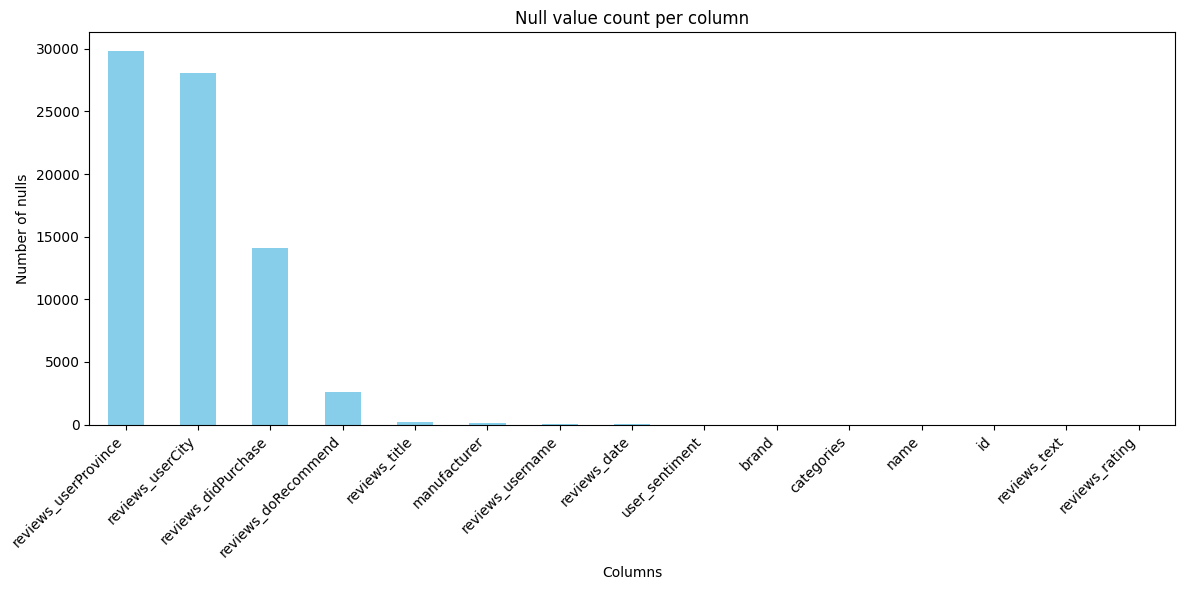

In [ ]:
# Display Null Value Counts
null_counts = reviews_df.isnull().sum() 
plt.figure(figsize=(12,6)) 
null_counts.sort_values(ascending=False).plot(kind='bar', color='skyblue') 
plt.title('Null value count per column') 
plt.ylabel('Number of nulls') 
plt.xlabel('Columns') 
plt.xticks(rotation=45, ha='right') 
plt.tight_layout() 
plt.show()

##### Since the columns ["reviews_userProvince", "reviews_userCity", "reviews_date", "reviews_doRecommend", "reviews_didPurchase"] have so many null values and do not contain any useful information we will drop these columns in the future

##### The ["reviews_username", "reviews_title", "user_sentiment", "manufacturer"] columns contains some null values which will be discarded later in Data Cleaning Step.


----

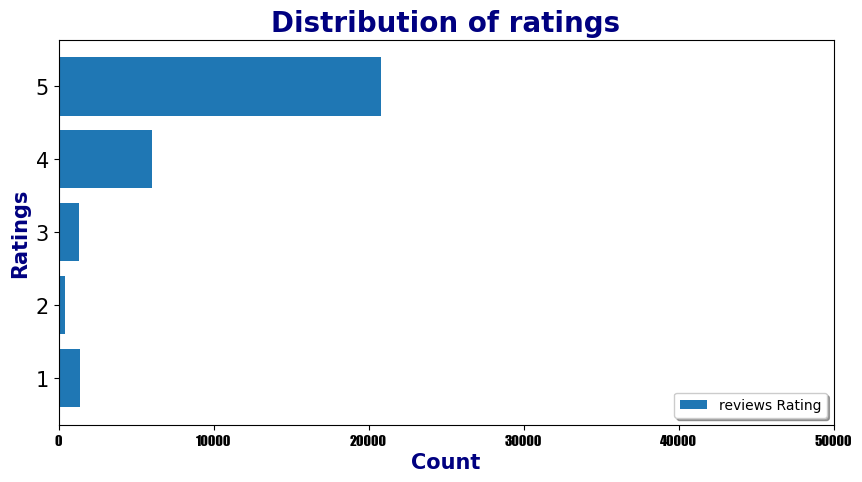

In [ ]:
# Number of occurrences for each rating
# plot ratings frequency
plt.figure(figsize=[10,5]) #[width, height]
x = list(reviews_df['reviews_rating'].value_counts().index)
y = list(reviews_df['reviews_rating'].value_counts())
plt.barh(x, y)
ticks_x = np.linspace(0, 50000, 6) # (start, end, no of ticks)
plt.xticks(ticks_x, fontsize=10, family='fantasy', color='black')
plt.yticks(size=15)

plt.title('Distribution of ratings', fontsize=20, weight='bold', color='navy', loc='center')
plt.xlabel('Count', fontsize=15, weight='bold', color='navy')
plt.ylabel('Ratings', fontsize=15, weight='bold', color='navy')
plt.legend(['reviews Rating'], shadow=True, loc=4)

C:\Users\Pratham Mhatre\AppData\Local\Temp\ipykernel_36436\1669160201.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  reviews_df['reviews_didPurchase'].fillna('No Data', inplace=True)


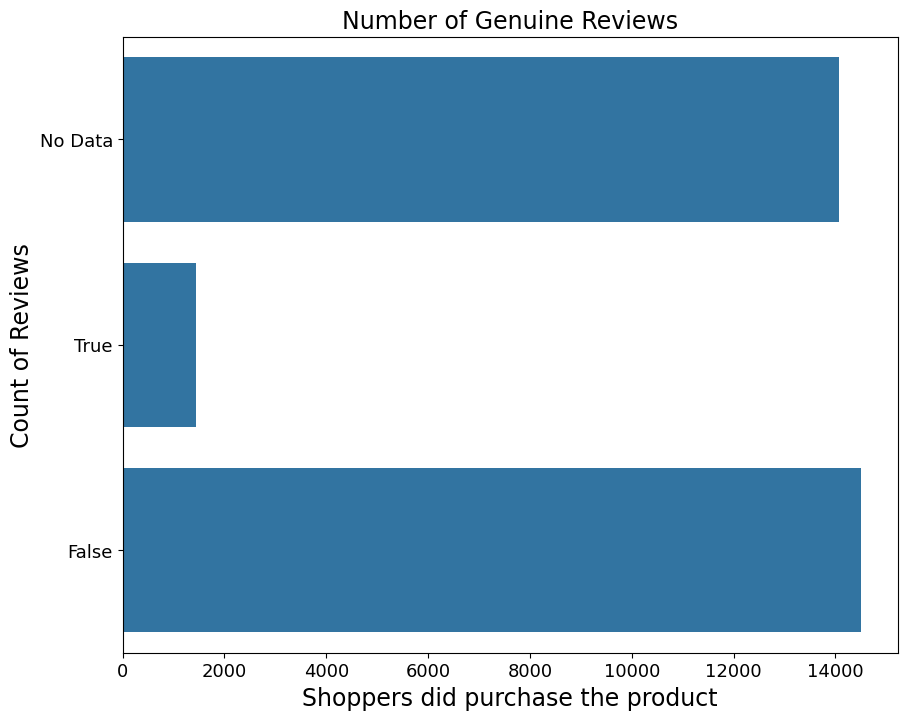

In [ ]:
# Number of Postive and Negatives in the data frame showing the class imbalance
# Replace the Nan values to No Data for reviewers did purchase or not
reviews_df['reviews_didPurchase'].fillna('No Data', inplace=True)

# Distribution of reviews for actual purchasing customers
plt.figure(figsize=(10,8))
ax = sns.countplot(reviews_df['reviews_didPurchase'])
ax.set_xlabel(xlabel="Shoppers did purchase the product", fontsize=17)
ax.set_ylabel(ylabel='Count of Reviews', fontsize=17)
ax.axes.set_title('Number of Genuine Reviews', fontsize=17)
ax.tick_params(labelsize=13)

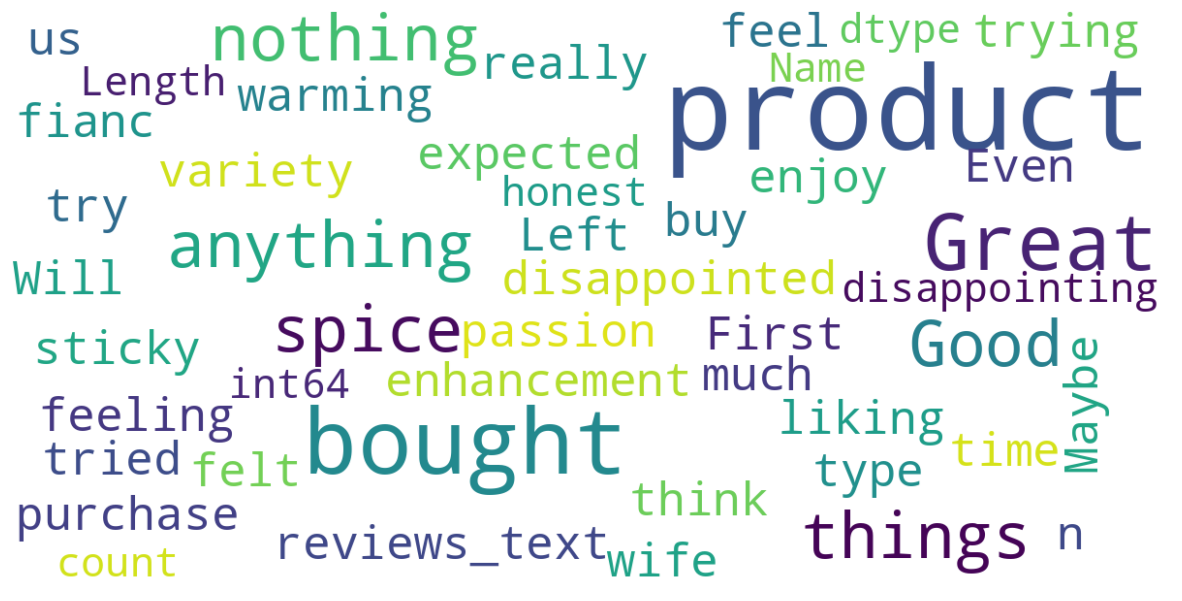

In [10]:
# To Check the most word occurence using word cloud
wc_stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color='white', stopwords=wc_stopwords, max_words=300, max_font_size=40,
                     scale=3, random_state=1).generate(str(reviews_df['reviews_text'].value_counts()))
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [11]:
# Drop the unnecessary columns
reviews_df = reviews_df.copy().drop(columns=["reviews_userProvince", "reviews_userCity", "reviews_date", "reviews_doRecommend", "reviews_didPurchase"])

df_dropped_list = reviews_df.columns.tolist()
df_dropped_list

['id',
 'brand',
 'categories',
 'manufacturer',
 'name',
 'reviews_rating',
 'reviews_text',
 'reviews_title',
 'reviews_username',
 'user_sentiment']

In [12]:
# Missing value audit
nulls = reviews_df.isna().sum().sort_values(ascending=False)
nulls_pct = (nulls / len(reviews_df) * 100).round(2)
missing_audit = pd.DataFrame({"missing_count": nulls, "missing_pct": nulls_pct})
display_dataframe_to_user("Missing Value Audit — Reviews", missing_audit)


Missing Value Audit — Reviews


,missing_count,missing_pct
reviews_title,190,0.63
manufacturer,141,0.47
reviews_username,63,0.21
user_sentiment,1,0.00
brand,0,0.00
id,0,0.00
reviews_rating,0,0.00
name,0,0.00
categories,0,0.00
reviews_text,0,0.00


## Phase 1 — Data Cleaning

In [13]:
# ============================================================
# Phase 1 — Data Cleaning
# Why: Make ratings numeric, drop critical nulls, fix types, dedupe.
# Save an “interim” clean file for reuse.
# ============================================================

INTERIM_DIR = BASE_DATA / "interim"
INTERIM_DIR.mkdir(parents=True, exist_ok=True)
CLEAN_PATH = INTERIM_DIR / "reviews_clean.csv"

df = reviews_df.copy()

# 1) Keep only columns we need; rename if needed
#    We’ll work with: id (product key), reviews_username, reviews_rating, reviews_text/title
needed = set(df.columns)
# Map flexible names if your raw differs
name_map = {}
for c in df.columns:
    cl = c.lower()
    if "id" in cl and "product" in cl:        name_map[c] = "id"
    if "user" in cl and "name" in cl:         name_map[c] = "reviews_username"
    if "rating" in cl:                        name_map[c] = "reviews_rating"
    if "review" in cl and ("text" in cl or "body" in cl): name_map[c] = "reviews_text"
    if "title" in cl and "review" in cl:      name_map[c] = "reviews_title"

df = df.rename(columns=name_map)

# 2) Coerce rating to numeric
df["reviews_rating"] = pd.to_numeric(df["reviews_rating"], errors="coerce")

# 3) Drop rows missing critical fields
crit_cols = ["id", "reviews_username", "reviews_rating", "manufacturer", "reviews_title", "user_sentiment"]
text_col = "reviews_text" if "reviews_text" in df.columns else (
    "reviews_title" if "reviews_title" in df.columns else None
)
if text_col is None:
    raise ValueError("No text column found. Expected one of: reviews_text or reviews_title")

crit_cols = crit_cols + [text_col]
before = len(df)
df = df.dropna(subset=crit_cols)
print(f"Dropped {before - len(df):,} rows with nulls in {crit_cols}")

# 4) Clamp ratings to [1,5] and drop outside
df = df[(df["reviews_rating"] >= 1) & (df["reviews_rating"] <= 5)]

# 5) Cast types
df["id"] = df["id"].astype(str)
df["reviews_username"] = df["reviews_username"].astype(str)

# 6) Deduplicate exact duplicates on (id, user, text)
dedup_keys = ["id", "reviews_username", text_col]
before = len(df)
df = df.drop_duplicates(subset=dedup_keys, keep="first")
print(f"Removed {before - len(df):,} duplicate rows using keys={dedup_keys}")

# 7) Save for Phase 2
df.to_csv(CLEAN_PATH, index=False)
print("Saved clean file:", CLEAN_PATH, "shape:", df.shape)


Dropped 394 rows with nulls in ['id', 'reviews_username', 'reviews_rating', 'manufacturer', 'reviews_title', 'user_sentiment', 'reviews_text']
Removed 1,792 duplicate rows using keys=['id', 'reviews_username', 'reviews_text']
Saved clean file: ..\data\interim\reviews_clean.csv shape: (27814, 10)


In [14]:
# Missing value audit
nulls = df.isna().sum().sort_values(ascending=False)
nulls_pct = (nulls / len(df) * 100).round(2)
missing_audit = pd.DataFrame({"missing_count": nulls, "missing_pct": nulls_pct})
display_dataframe_to_user("Missing Value Audit — Reviews", missing_audit)


Missing Value Audit — Reviews


,missing_count,missing_pct
id,0,0.0
brand,0,0.0
categories,0,0.0
manufacturer,0,0.0
name,0,0.0
reviews_rating,0,0.0
reviews_text,0,0.0
reviews_title,0,0.0
reviews_username,0,0.0
user_sentiment,0,0.0


## Phase 2 — Sentiment Labels & Text Preprocessing

In [15]:
# ============================================================
# Phase 2 — Sentiment Labels & Text Preprocessing
# Why: Remove neutrals (3 stars), binarize labels, clean text.
# Save “labeled” file for modeling.
# ============================================================

CLEAN_INPUT   = INTERIM_DIR / "reviews_clean.csv"
LABELED_PATH  = INTERIM_DIR / "reviews_labeled.csv"

df = pd.read_csv(CLEAN_INPUT)

In [16]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to C:\Users\Pratham
[nltk_data]     Mhatre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Pratham
[nltk_data]     Mhatre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Pratham Mhatre\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to C:\Users\Pratham
[nltk_data]     Mhatre\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# 1) Binary label: positive (>=4) -> 1, negative (<=2) -> 0; drop rating == 3
pos_mask = df["reviews_rating"] >= 4
neg_mask = df["reviews_rating"] <= 2
neu_mask = df["reviews_rating"] == 3
print(f"Removed neutrals (rating==3): {neu_mask.sum():,}")

df = df.loc[pos_mask | neg_mask].copy()
df["label"] = (df["reviews_rating"] >= 4).astype(int)

# 2) Clean text (simple, fast, with negation binding)
text_col = "reviews_text" if "reviews_text" in df.columns else "reviews_title"

# ===== NLTK-based cleaner (negation + POS lemmatization) ==========
# Base stopwords + a few extras you had before
STOP = set(stopwords.words("english"))
STOP.update({
    "a","an","the","and","or","but","if","while","on","in","at","to","for","from","by","of",
    "is","are","was","were","be","been","being","this","that","those","these",
    "i","you","he","she","it","we","they","me","him","her","us","them","my","your","his","its","our","their",
    "as","with","without"  # keep 'not' OUT of stopwords
})

_PUNCT_SET = set(string.punctuation)
_LEM = WordNetLemmatizer()

def _wn_pos(tag: str):
    if not tag: return wn.NOUN
    c = tag[0]
    return wn.ADJ if c == "J" else wn.VERB if c == "V" else wn.NOUN if c == "N" else wn.ADV if c == "R" else wn.NOUN

def clean_text(s: str) -> str:
    if not isinstance(s, str):
        return ""
    # lowercase + strip html/urls
    s = s.lower()
    s = re.sub(r"<[^>]+>", " ", s)
    s = re.sub(r"http\S+|www\.\S+", " ", s)
    # normalize common negation contraction to "not"
    s = re.sub(r"n't\b", " not", s)
    s = re.sub(r"\s+", " ", s).strip()

    # tokenize
    toks = word_tokenize(s)

    # mark negation scope -> adds _NEG suffix until next punctuation
    toks = mark_negation(toks)  # e.g., ["not", "good"] -> ["not", "good_NEG"]

    # drop pure punctuation tokens and pure numbers
    toks = [t for t in toks if t not in _PUNCT_SET and not re.fullmatch(r"\d+", t)]

    # POS tagging on base tokens (strip _NEG for tagging)
    base_for_tag = [t.replace("_NEG", "") for t in toks]
    try:
        tags = pos_tag(base_for_tag)
    except Exception:
        # If tagger not available/offline, fake "NN" tags
        tags = [(w, "NN") for w in base_for_tag]

    out = []
    for (base, tag), tok in zip(tags, toks):
        lemma = _LEM.lemmatize(base, pos=_wn_pos(tag))

        if tok.endswith("_NEG"):
            # keep negated tokens even if the base is a stopword -> convert to not_<lemma>
            out.append(f"not_{lemma}")
        else:
            # standard stopword & length filter
            if lemma in STOP: 
                continue
            if len(lemma) < 2:
                continue
            # remove leftover punctuation-only tokens
            if all(ch in _PUNCT_SET for ch in lemma):
                continue
            out.append(lemma)

    return " ".join(out)


df["clean_text"] = df[text_col].apply(clean_text)

# 3) Save + quick check
print(df["label"].value_counts(normalize=True).rename({0:"neg",1:"pos"}).round(3))
df[["clean_text", "reviews_rating", "label"]].head(10)

df.to_csv(LABELED_PATH, index=False)
print("Saved labeled file:", LABELED_PATH, "shape:", df.shape)


Removed neutrals (rating==3): 1,205
label
pos    0.946
neg    0.054
Name: proportion, dtype: float64
Saved labeled file: ..\data\interim\reviews_labeled.csv shape: (26609, 12)


## Phase 3 — Train/Test Split + Vectorizers (Count vs TF-IDF)

In [18]:
# ============================================================
# Phase 3 — Train/Test Split + Vectorizers (Count vs TF-IDF)
# Why: Prevent leakage; compare feature extractors per rubric.
# ============================================================

ARTIFACTS = Path("../artifacts")
ARTIFACTS.mkdir(parents=True, exist_ok=True)

# Added "keep_default_na=False" to prevent the automatic conversion of empty strings to NaN
labeled = pd.read_csv(LABELED_PATH, keep_default_na=False)
X = labeled["clean_text"]
y = labeled["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Vectorizer configs (common sensible defaults)
count_vec = CountVectorizer(
    ngram_range=(1,2),
    min_df=2,
    max_df=0.9
)
tfidf_vec = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=2,
    max_df=0.9,
    norm="l2",
    sublinear_tf=True
)

# Fit on TRAIN only; transform both (prevents leakage)
Xtr_count = count_vec.fit_transform(X_train)
Xte_count = count_vec.transform(X_test)

Xtr_tfidf = tfidf_vec.fit_transform(X_train)
Xte_tfidf = tfidf_vec.transform(X_test)

# Persist vectorizers for the chosen model later
joblib.dump(count_vec, ARTIFACTS / "count_vectorizer.pkl")
joblib.dump(tfidf_vec, ARTIFACTS / "tfidf_vectorizer.pkl")
print("Saved vectorizers to:", ARTIFACTS)


Saved vectorizers to: ..\artifacts


In [19]:
# ============================================================
# Phase 4 — Sentiment Models (LogReg, MultinomialNB, XGBoost*)
# Why: Build ≥3 models, compare on F1, pick one, save artifacts.
# ============================================================

# Optional XGBoost (guard if not installed)
try:
    from xgboost import XGBClassifier
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False

def eval_model(name, Xtr, ytr, Xte, yte, model):
    model.fit(Xtr, ytr)
    y_pred = model.predict(Xte)
    acc = accuracy_score(yte, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(yte, y_pred, average="binary", zero_division=0)

    # ROC AUC only if predict_proba available and both classes present
    try:
        proba = model.predict_proba(Xte)[:,1]
        auc = roc_auc_score(yte, proba) if len(np.unique(yte)) == 2 else np.nan
    except Exception:
        auc = np.nan

    return {
        "model": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": auc,
        "has_proba": hasattr(model, "predict_proba"),
    }

results = []

# --- Logistic Regression (Count & TF-IDF)
logreg = LogisticRegression(max_iter=200, class_weight="balanced")
results.append(eval_model("LogReg_count",  Xtr_count, y_train, Xte_count, y_test, logreg))
logreg_tfidf = LogisticRegression(max_iter=200, class_weight="balanced")
results.append(eval_model("LogReg_tfidf", Xtr_tfidf, y_train, Xte_tfidf, y_test, logreg_tfidf))

# --- Multinomial NB (Count & TF-IDF)
nb = MultinomialNB()
results.append(eval_model("MultinomialNB_count",  Xtr_count, y_train, Xte_count, y_test, nb))
nb_tfidf = MultinomialNB()
results.append(eval_model("MultinomialNB_tfidf", Xtr_tfidf, y_train, Xte_tfidf, y_test, nb_tfidf))

# --- XGBoost (optional)
if XGB_AVAILABLE:
    xgb_count = XGBClassifier(
        n_estimators=300, max_depth=6, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
        objective="binary:logistic", eval_metric="logloss", random_state=42
    )

    xgb_tfidf = XGBClassifier(
        n_estimators=300, max_depth=6, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
        objective="binary:logistic", eval_metric="logloss", random_state=42
    )

    results.append(eval_model("XGB_count", Xtr_count, y_train, Xte_count, y_test, xgb_count))
    results.append(eval_model("XGB_tfidf", Xtr_tfidf, y_train, Xte_tfidf, y_test, xgb_tfidf))

res_df = pd.DataFrame(results)
res_df["features"] = res_df["model"].str.contains("tfidf").map({True:"tfidf", False:"count"})
res_df["base"] = res_df["model"].str.replace("_count","").str.replace("_tfidf","")
res_df = res_df.sort_values("f1", ascending=False).reset_index(drop=True)
display(res_df)


,model,accuracy,precision,recall,f1,roc_auc,has_proba,features,base
0,XGB_count,0.971064,0.974349,0.995631,0.984875,0.954148,True,count,XGB
1,XGB_tfidf,0.971064,0.975828,0.994043,0.984851,0.955807,True,tfidf,XGB
2,LogReg_count,0.966742,0.983483,0.981334,0.982407,0.949394,True,count,LogReg
3,MultinomialNB_tfidf,0.954340,0.953969,1.000000,0.976442,0.934842,True,tfidf,MultinomialNB
4,MultinomialNB_count,0.952649,0.982647,0.967037,0.974780,0.937109,True,count,MultinomialNB
5,LogReg_tfidf,0.950958,0.988541,0.959293,0.973697,0.965395,True,tfidf,LogReg


In [20]:
# ------------------------------------------------------------
# Select best by F1 and persist model + meta
# ------------------------------------------------------------
best = res_df.iloc[0]
best_model_name = best["model"]
best_feat = best["features"]
print("Best:", best_model_name, "using", best_feat)

# Map back to fitted instances (already trained above on train)
model_map = {
    "LogReg_count": logreg,
    "LogReg_tfidf": logreg_tfidf,
    "MultinomialNB_count": nb,
    "MultinomialNB_tfidf": nb_tfidf
}
if XGB_AVAILABLE:
    model_map["XGB_count"] = xgb_count
    model_map["XGB_tfidf"] = xgb_tfidf

best_model = model_map[best_model_name]

# Choose vectorizer file path
vec_file = ARTIFACTS / ("tfidf_vectorizer.pkl" if best_feat=="tfidf" else "count_vectorizer.pkl")

# Save model + meta
joblib.dump(best_model, ARTIFACTS / "sentiment_model.pkl")
meta = {
    "best_model": best_model_name,
    "features": best_feat,
    "vectorizer_file": vec_file.name,
    "metrics": {
        "accuracy": float(best["accuracy"]),
        "precision": float(best["precision"]),
        "recall": float(best["recall"]),
        "f1": float(best["f1"]),
        "roc_auc": None if pd.isna(best.get("roc_auc", np.nan)) else float(best["roc_auc"]),
    }
}
pd.Series(meta).to_json(ARTIFACTS / "sentiment_model_meta.json")
print("Saved model + meta to:", ARTIFACTS)


Best: XGB_count using count
Saved model + meta to: ..\artifacts


## Phase 5 — Recommendation System Building

In [ ]:
# ============================================================
# Phase 5 — Recommendation System
# Why: Build a simple content-based recommender using TF-IDF/Count Vectorizer.
# Step 5.0 — Setup
# ============================================================

ARTIFACTS_DIR = Path("../artifacts")
RECSYS_DIR    = ARTIFACTS_DIR / "recsys"
DATA_INTERIM  = Path("../data/interim")
RECSYS_DIR.mkdir(parents=True, exist_ok=True)

# Reuse sentiment artifacts from Phase 4 (already created)
sent_meta    = json.loads((ARTIFACTS_DIR / "sentiment_model_meta.json").read_text())
vectorizer   = joblib.load(ARTIFACTS_DIR / sent_meta["vectorizer_file"])
sent_model   = joblib.load(ARTIFACTS_DIR / "sentiment_model.pkl")

RNG = np.random.RandomState(42)  # fixed local RNG


In [ ]:
# ============================================================
# Step 5.1 — Load cleaned reviews and build binary labels
# ============================================================
clean_fp = DATA_INTERIM / "reviews_clean.csv"
df = pd.read_csv(clean_fp)

# Keep only rows with non-null user, item, rating
df = df.dropna(subset=["reviews_username","id","reviews_rating"]).copy()
df["reviews_username"] = df["reviews_username"].astype(str).str.strip()
df["id"] = df["id"].astype(str).str.strip()

# Binary interaction: positive if rating >=4 (drop 3/neutral)
df = df[df["reviews_rating"] != 3]
df["y"] = (df["reviews_rating"] >= 4).astype(int)

# We only keep positives for implicit feedback (interaction matrix)
pos = df[df["y"] == 1][["reviews_username","id"]].drop_duplicates().copy()
print(f"Positives kept: {len(pos):,}  | Users: {pos['reviews_username'].nunique():,}  | Items: {pos['id'].nunique():,}")


Positives kept: 24,715  | Users: 22,438  | Items: 239


In [ ]:
# ============================================================
# Step 5.2 — Build mappings and user–item CSR
# ============================================================
users = sorted(pos["reviews_username"].unique().tolist())
items = sorted(pos["id"].unique().tolist())
user_map = {u:i for i,u in enumerate(users)}
item_map = {it:i for i,it in enumerate(items)}

# Create sparse matrix: rows = user indices, cols = item indices, data = 1s (implicit feedback)
rows = pos["reviews_username"].map(user_map).to_numpy()
cols = pos["id"].map(item_map).to_numpy()
data = np.ones(len(pos), dtype=np.float32)

R = csr_matrix((data, (rows, cols)), shape=(len(users), len(items)))
R = R.tocsr()

# Save mappings and matrix
joblib.dump(user_map, RECSYS_DIR/"user_map.pkl")
joblib.dump(item_map, RECSYS_DIR/"item_map.pkl")
joblib.dump(R,        RECSYS_DIR/"rating_matrix_all.pkl")
print("R shape:", R.shape, "| nnz:", R.nnz)


R shape: (22438, 239) | nnz: 24715


In [ ]:
# ============================================================
# Step 5.3 — Make per-user train/test holdout
# ============================================================
def split_train_test_per_user(R, test_frac=0.2, rng=RNG):
    R = R.tocsr()
    n_users, n_items = R.shape
    train_rows, train_cols, train_data = [], [], []
    test_rows,  test_cols,  test_data  = [], [], []

    indptr = R.indptr
    indices = R.indices
    data = R.data

    for u in range(n_users):
        start, end = indptr[u], indptr[u+1]
        items_u = indices[start:end]
        if len(items_u) <= 1:
            # cannot split; keep all in train
            train_rows.extend([u]*len(items_u))
            train_cols.extend(items_u.tolist())
            train_data.extend([1.0]*len(items_u))
            continue
        k = max(1, int(round(len(items_u)*test_frac)))
        test_idx = rng.choice(len(items_u), size=k, replace=False)
        test_items = set(items_u[test_idx])
        for it in items_u:
            if it in test_items:
                test_rows.append(u); test_cols.append(it); test_data.append(1.0)
            else:
                train_rows.append(u); train_cols.append(it); train_data.append(1.0)

    R_train = csr_matrix((train_data, (train_rows, train_cols)), shape=R.shape).tocsr()
    R_test  = csr_matrix((test_data,  (test_rows,  test_cols)),  shape=R.shape).tocsr()
    return R_train, R_test

# Split the data into train and test sets
R_train, R_test = split_train_test_per_user(R, test_frac=0.2, rng=RNG)
joblib.dump(R_train, RECSYS_DIR/"rating_matrix_train.pkl")
joblib.dump(R_test,  RECSYS_DIR/"rating_matrix_test.pkl")
print("Train nnz:", R_train.nnz, "| Test nnz:", R_test.nnz)


Train nnz: 23019 | Test nnz: 1696


In [25]:
# ============================================================
# Step 5.4 — Precompute item-item cosine; cache user norms
# ============================================================
# Normalize item columns before cosine to be robust
Rtr_csc = R_train.tocsc(copy=True)
# binary data: leave as is; cosine_similarity will handle sparse
SIM_ITEM = cosine_similarity(Rtr_csc.T, dense_output=False)  # (n_items x n_items), sparse
joblib.dump(SIM_ITEM, RECSYS_DIR/"sim_item_cosine.pkl")

# user vector norms for on-the-fly user sims
user_norms = np.sqrt((R_train.multiply(R_train)).sum(axis=1)).A1 + 1e-12
joblib.dump(user_norms, RECSYS_DIR/"user_norms.pkl")


['..\\artifacts\\recsys\\user_norms.pkl']

In [ ]:
# ============================================================
# Step 5.5 — Cold-start helper (popularity + sentiment + tiny noise)
# ============================================================
def load_item_sentiment_stats():
    fp = RECSYS_DIR / "item_sentiment_stats.csv"
    if fp.exists():
        return pd.read_csv(fp)
    # Allow missing at first run; will be created in Phase 7
    return pd.DataFrame()

# Cold-start recommendations
def _cold_start_recs(uidx, Rtr, topn, item_map, item_sent_df=None):
    I = Rtr.shape[1]
    pop = np.asarray(Rtr.sum(axis=0)).ravel().astype(float)
    if pop.max() > pop.min():
        pop = (pop - pop.min()) / (pop.max() - pop.min())
    else:
        pop = np.zeros_like(pop)

    sent = np.zeros(I, dtype=float)
    if item_sent_df is not None and not item_sent_df.empty:
        idx_to_key = {v:k for k,v in item_map.items()}
        pos_pct = item_sent_df.set_index(item_sent_df.columns[0])["positive_pct"]
        med = float(pos_pct.median()) if len(pos_pct) else 0.5
        for i in range(I):
            key = idx_to_key[i]
            sent[i] = float(pos_pct.get(key, med))
        if sent.max() > sent.min():
            sent = (sent - sent.min()) / (sent.max() - sent.min())
        else:
            sent[:] = 0.5
    else:
        sent[:] = 0.5

    rng = np.random.RandomState(uidx * 31 + 17)  # per-user deterministic
    noise = rng.normal(0.0, 0.01, size=I)

    fused = 0.7 * pop + 0.3 * sent + noise
    N = min(topn, I)
    top_idx = np.argpartition(-fused, N-1)[:N]
    top_idx = top_idx[np.argsort(-fused[top_idx])]
    return top_idx[:topn], fused[top_idx][:topn]

item_sent_stats = load_item_sentiment_stats()


In [ ]:
# ============================================================
# Step 5.6 — Recommenders (item-based + user-based)
# ============================================================

# Item-based recommendations
def recommend_item_based(Rtr, SIM_ITEM, uidx, topn=20):
    seen = set(Rtr[uidx].indices)
    if len(seen) == 0:
        return _cold_start_recs(uidx, Rtr, topn, item_map, item_sent_df=item_sent_stats)

    # score = SIM_ITEM @ user profile (only unseen)
    scores = np.zeros(Rtr.shape[1], dtype=float)
    prof_items = Rtr[uidx].indices
    for it in prof_items:
        # SIM_ITEM is sparse; get column for 'it'
        sims = SIM_ITEM.getcol(it).toarray().ravel()
        scores += sims
    if seen:
        scores[list(seen)] = -np.inf

    if not np.isfinite(scores).any():
        return _cold_start_recs(uidx, Rtr, topn, item_map, item_sent_df=item_sent_stats)

    N = min(topn, (scores > -np.inf).sum())
    rec_idx = np.argpartition(-scores, N-1)[:N]
    rec_idx = rec_idx[np.argsort(-scores[rec_idx])]
    return rec_idx, scores[rec_idx]

# User-based recommendations
def recommend_user_based(Rtr, uidx, topn=20, k=50, user_norms=None):
    seen = set(Rtr[uidx].indices)
    if len(seen) < 2:
        return _cold_start_recs(uidx, Rtr, topn, item_map, item_sent_df=item_sent_stats)

    # find candidate users via co-rated items
    Rtr_csc = Rtr.tocsc()
    cand_users = set()
    for it in Rtr[uidx].indices:
        cand_users.update(Rtr_csc[:, it].indices)
    cand_users.discard(uidx)
    if not cand_users:
        return _cold_start_recs(uidx, Rtr, topn, item_map, item_sent_df=item_sent_stats)

    # cosine(u, v) = dot / (||u||*||v||)
    urow = Rtr[uidx]
    u_norm = user_norms[uidx] if user_norms is not None else np.sqrt(urow.multiply(urow).sum()) + 1e-12
    dots = []
    cand_list = list(cand_users)
    for cu in cand_list:
        dot = urow.multiply(Rtr[cu]).sum()
        v_norm = user_norms[cu] if user_norms is not None else np.sqrt(Rtr[cu].multiply(Rtr[cu]).sum()) + 1e-12
        sim = float(dot / (u_norm * v_norm)) if (u_norm * v_norm) > 0 else 0.0
        dots.append(sim)
    sims = np.array(dots, dtype=float)

    # top-k positive sims
    mask_pos = sims > 0
    cand_list = [c for c,ok in zip(cand_list, mask_pos) if ok]
    sims      = sims[mask_pos]
    if len(cand_list) == 0:
        return _cold_start_recs(uidx, Rtr, topn, item_map, item_sent_df=item_sent_stats)

    if len(cand_list) > k:
        top_idx = np.argpartition(-sims, k-1)[:k]
        cand_list = [cand_list[i] for i in top_idx]
        sims = sims[top_idx]

    weights = sims / sims.sum()
    scores = np.zeros(Rtr.shape[1], dtype=float)
    for w, cu in zip(weights, cand_list):
        scores[Rtr[cu].indices] += w  # implicit vote

    # tie-break with tiny per-user noise
    rng = np.random.RandomState(uidx * 101 + 911)
    scores += rng.rand(scores.shape[0]) * 1e-3

    if seen:
        scores[list(seen)] = -np.inf

    if not np.isfinite(scores).any():
        return _cold_start_recs(uidx, Rtr, topn, item_map, item_sent_df=item_sent_stats)

    N = min(topn, (scores > -np.inf).sum())
    rec_idx = np.argpartition(-scores, N-1)[:N]
    rec_idx = rec_idx[np.argsort(-scores[rec_idx])]
    return rec_idx, scores[rec_idx]


In [ ]:
# ============================================================
# Step 5.7 — Evaluation routines
# ============================================================

def precision_recall_at_k(Rtr, Rte, topn, recommender_fn, k_neighbors=50):
    n_users = Rtr.shape[0]
    p_list, r_list, h_list = [], [], []
    Rte = Rte.tocsr()
    for u in range(n_users):
        test_items = set(Rte[u].indices)
        if not test_items:
            continue
        rec_idx, _ = recommender_fn(u)
        rec_set = set(rec_idx[:topn])
        hit = len(test_items & rec_set)
        p = hit / float(topn)
        r = hit / float(len(test_items))
        h = 1.0 if hit > 0 else 0.0
        p_list.append(p); r_list.append(r); h_list.append(h)
    return (np.mean(p_list) if p_list else 0.0,
            np.mean(r_list) if r_list else 0.0,
            np.mean(h_list) if h_list else 0.0)

topn, k = 20, 50
p_item, r_item, h_item = precision_recall_at_k(
    R_train, R_test, topn,
    lambda u: recommend_item_based(R_train, SIM_ITEM, u, topn=topn)
)
p_user, r_user, h_user = precision_recall_at_k(
    R_train, R_test, topn,
    lambda u: recommend_user_based(R_train, u, topn=topn, k=k, user_norms=user_norms)
)

pd.DataFrame({
    "cf": ["item","user"],
    "precision@20":[p_item, p_user],
    "recall@20":   [r_item, r_user],
    "hit-rate@20": [h_item, h_user]
})


,cf,precision@20,recall@20,hit-rate@20
0,item,0.024420,0.484037,0.486020
1,user,0.038816,0.773250,0.774539


In [ ]:
# ============================================================
# Step 5.8 — Select final CF and save meta + wrappers
# ============================================================
# Choose the better CF by recall (tie-break by precision)
if (r_item, p_item) >= (r_user, p_user):
    final_cf = "item"
else:
    final_cf = "user"

recsys_meta = {
    "final_cf": final_cf,
    "topn": 20,
    "k_neighbors": 50,
    "item_key_column": "id"
}
(RECSYS_DIR / "recsys_meta.json").write_text(json.dumps(recsys_meta, indent=2))

# Top-N recommendations for a user
def top20_for_user(uidx, topn=20):
    if final_cf == "user":
        rec_idx, scores = recommend_user_based(R_train, uidx, topn=topn, k=50, user_norms=user_norms)
    else:
        rec_idx, scores = recommend_item_based(R_train, SIM_ITEM, uidx, topn=topn)
    return pd.DataFrame({
        "rank": np.arange(1, len(rec_idx)+1),
        "id":   [list(item_map.keys())[list(item_map.values()).index(i)] for i in rec_idx],
        "score": scores
    })

print("Selected CF:", final_cf)


Selected CF: user


## Phase 6 — Recommend Top-20 Products for a User

In [ ]:
# ============================================================
# Phase 6 — Recommend Top-20 Products for a User
# Why: Generate personalized product recommendations for a user.
# ============================================================
def top20_for_user(uidx, topn=20):
    """Return Top-N recommendations for given user index using final CF."""
    if final_cf == "user":
        rec_idx, scores = recommend_user_based(R_train, uidx, topn=topn, k=50, user_norms=user_norms)
    else:
        rec_idx, scores = recommend_item_based(R_train, SIM_ITEM, uidx, topn=topn)
    
    df_top20 = pd.DataFrame({
        "rank": np.arange(1, len(rec_idx)+1),
        "id":   [list(item_map.keys())[list(item_map.values()).index(i)] for i in rec_idx],
        "score": scores
    })
    return df_top20

# Example: pick a known username
sample_user = users[0]  # first user in mapping
uidx = user_map[sample_user]
top20 = top20_for_user(uidx)
top20.head(10)


,rank,id,score
0,1,AVpf3VOfilAPnD_xjpun,0.995414
1,2,AVpfPaoqLJeJML435Xk9,0.543909
2,3,AVpfJP1C1cnluZ0-e3Xy,0.434679
3,4,AVpfRTh1ilAPnD_xYic2,0.401430
4,5,AVpf0eb2LJeJML43EVSt,0.377153
5,6,AVpf2tw1ilAPnD_xjflC,0.369423
6,7,AVpf63aJLJeJML43F__Q,0.368432
7,8,AVpe41TqilAPnD_xQH3d,0.357839
8,9,AVpf9pzn1cnluZ0-uNTM,0.354882
9,10,AVpfW8y_LJeJML437ySW,0.342879


## Phase 7 — Sentiment Re-ranking

In [ ]:
# ============================================================
# Step 7.1 — Compute or load item-level sentiment stats
# Why: Improve recommendation relevance by incorporating item sentiment.
# ============================================================

ARTIFACTS_DIR = Path("../artifacts")
RECSYS_DIR = ARTIFACTS_DIR / "recsys"

# Reuse selected sentiment artifacts from Phase 4
sent_meta  = json.loads((ARTIFACTS_DIR / "sentiment_model_meta.json").read_text())
vectorizer = joblib.load(ARTIFACTS_DIR / sent_meta["vectorizer_file"])
sent_model = joblib.load(ARTIFACTS_DIR / "sentiment_model.pkl")

def _predict_sentiment_batch(texts, batch=4096):
    """Predict 0/1 (neg/pos) in batches using the chosen sentiment model."""
    out = []
    for i in range(0, len(texts), batch):
        X = vectorizer.transform(texts[i:i+batch])
        y = sent_model.predict(X)
        out.extend(y.tolist())
    return np.array(out, dtype=int)

def build_or_load_item_sentiment_stats(df_reviews, force_rebuild=False):
    """
    Creates/loads 'item_sentiment_stats.csv' with columns:
      id, reviews_total, positive_pct
    """
    fp = RECSYS_DIR / "item_sentiment_stats.csv"
    if fp.exists() and not force_rebuild:
        return pd.read_csv(fp)

    # Aggregate total reviews per item (use the same cleaned dataframe as Phase 5)
    agg = df_reviews.groupby("id", as_index=False).agg(
        reviews_total=("reviews_text","count")
    )

    # Predict sentiments for all reviews
    texts = df_reviews["reviews_text"].fillna("").astype(str).tolist()
    y_hat = _predict_sentiment_batch(texts)

    tmp = df_reviews[["id"]].copy()
    tmp["pred"] = y_hat
    pos_rate = tmp.groupby("id")["pred"].mean().rename("positive_pct").reset_index()

    item_sent = agg.merge(pos_rate, on="id", how="left")
    item_sent["positive_pct"] = item_sent["positive_pct"].fillna(item_sent["positive_pct"].median())

    RECSYS_DIR.mkdir(parents=True, exist_ok=True)
    item_sent.to_csv(fp, index=False)
    return item_sent

# df (cleaned reviews) already exists from Phase 5.1
item_sent_stats = build_or_load_item_sentiment_stats(df, force_rebuild=False)
item_sent_stats.head()


,id,reviews_total,positive_pct
0,AV13O1A8GV-KLJ3akUyj,1,1.000000
1,AV14LG0R-jtxr-f38QfS,2,1.000000
2,AV16khLE-jtxr-f38VFn,25,0.600000
3,AV1YGDqsGV-KLJ3adc-O,323,0.916409
4,AV1YIch7GV-KLJ3addeG,1,1.000000


In [ ]:
# ============================================================
# Step 7.2 — Turn Phase-6 Top-20 into Top-5 using sentiment
# ============================================================

# Rerank Top-20 recommendations using item sentiment
def rerank_top20_with_sentiment(top20_df, item_sent_stats, min_reviews=5, alpha=0.7):
    """
    Inputs:
      - top20_df: output of Phase 6's top20_for_user(uidx)
                  columns expected: ['rank','id','score']
      - item_sent_stats: DataFrame with ['id','reviews_total','positive_pct']
      - alpha: weight for sentiment (0..1); (1-alpha) for CF score

    Returns:
      DataFrame with Top-5 columns: ['id','positive_pct','reviews_total','fused']
      (You can join names later for display.)
    """
    # Join sentiment stats
    df = top20_df.merge(item_sent_stats, on="id", how="left")

    # Fill missing sentiment stats robustly
    df["reviews_total"] = df["reviews_total"].fillna(0)
    med = df["positive_pct"].median() if "positive_pct" in df and df["positive_pct"].notna().any() else 0.5
    df["positive_pct"] = df["positive_pct"].fillna(med)

    # Normalize CF and sentiment
    cf  = df["score"].astype(float).to_numpy()
    pct = df["positive_pct"].astype(float).to_numpy()

    cf_n  = (cf - cf.min())  / (cf.max()  - cf.min()  + 1e-12)
    pct_n = (pct - pct.min())/ (pct.max() - pct.min() + 1e-12)

    # Fuse: higher is better
    df["fused"] = alpha * pct_n + (1 - alpha) * cf_n

    # Prefer items with adequate review volume if we still have >=5
    filtered = df[df["reviews_total"] >= min_reviews]
    if len(filtered) >= 5:
        df = filtered

    top5 = df.sort_values("fused", ascending=False).head(5).copy()
    return top5[["id", "positive_pct", "reviews_total", "fused"]].reset_index(drop=True)

# 🔎 Quick demo (explicit Phase-6 -> Phase-7 flow)
sample_username = users[0]
uidx = user_map[sample_username]
top20 = top20_for_user(uidx, topn=20)           # <-- Phase 6 output
top5  = rerank_top20_with_sentiment(top20, item_sent_stats, min_reviews=5, alpha=0.7)
top5


,id,positive_pct,reviews_total,fused
0,AVpf3VOfilAPnD_xjpun,0.999098,7758,0.952235
1,AVpe_y-I1cnluZ0-bmvh,1.000000,61,0.704770
2,AVpfR5m0LJeJML436K3W,1.000000,194,0.701233
3,AVpe8gsILJeJML43y6Ed,1.000000,285,0.700272
4,AVpfRTh1ilAPnD_xYic2,0.997263,1096,0.590559


In [33]:
# Optional: show names for inspection (not required by the function)
try:
    mappings = joblib.load(ARTIFACTS_DIR / "mappings.pkl")
    id_to_name = mappings.get("id_to_name", {})
    preview = top5.copy()
    preview["item_name"] = preview["id"].map(id_to_name).fillna(preview["id"])
    preview[["id","item_name","positive_pct","reviews_total","fused"]]
except Exception:
    top5


## Testing

Test the recommendation for a random user

Selected Random User: boo boo

Top 5 Recommended Products:


,rank,id,item_name,positive_pct,reviews_total,fused
0,1,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,0.999098,7758,0.974209
1,2,AVpfKb8k1cnluZ0-fQdA,Head & Shoulders Classic Clean Conditioner,1.000000,70,0.704603
2,3,AVpfBrUZilAPnD_xTUly,"Coty Airspun Face Powder, Translucent Extra Co...",1.000000,150,0.702010
3,4,AVpf4oLxLJeJML43FcxC,Avery174 Ready Index Contemporary Table Of Con...,1.000000,267,0.701842
4,5,AVpfoSS51cnluZ0-oVH9,Cheetos Crunchy Flamin' Hot Cheese Flavored Sn...,1.000000,59,0.701318


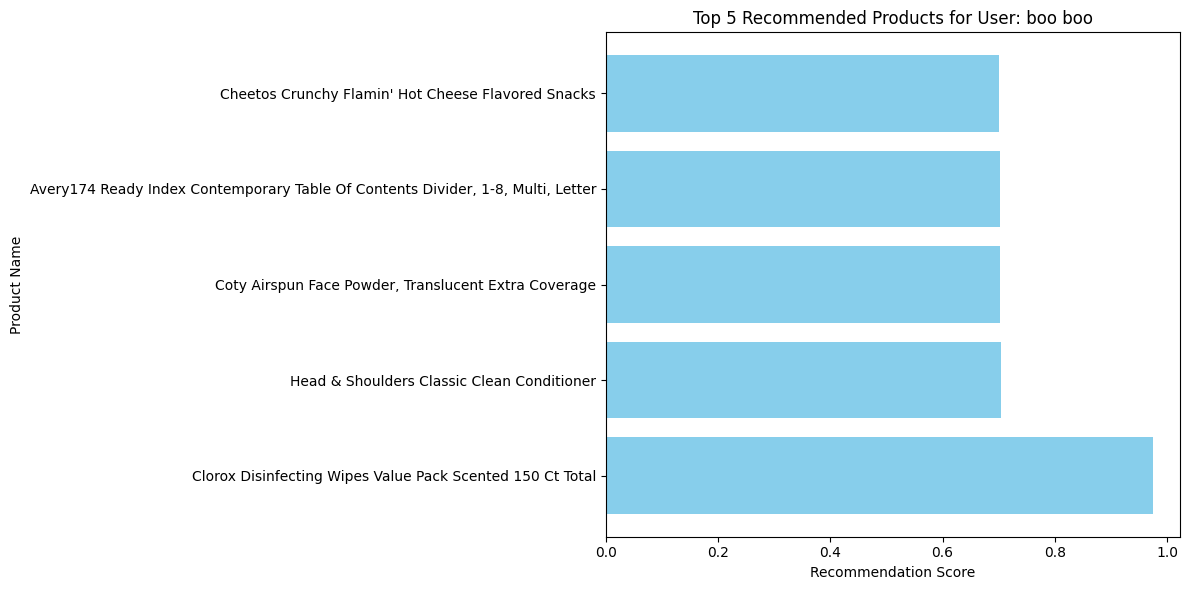

In [34]:
# ============================================================
# Displaying Top 5 Recommendations for a Random User with Item Names
# ============================================================

# Function to get item names from product IDs
def get_item_names(product_ids):
    """
    Get product names for given product IDs
    """
    # Create a mapping from product ID to name using the cleaned dataset
    id_to_name = {}
    
    # Use the cleaned dataframe which contains all product information
    for _, row in df.drop_duplicates(subset=['id']).iterrows():
        product_id = row['id']
        # Use 'name' column if it exists, otherwise use manufacturer + product ID as fallback
        if 'name' in df.columns:
            product_name = row['name']
        else:
            product_name = f"{row['manufacturer']} - {product_id}"
        id_to_name[product_id] = product_name
    
    # Map product IDs to names
    return [id_to_name.get(pid, f"Unknown Product ({pid})") for pid in product_ids]

# Select a random user
random_user = random.choice(users)
print(f"Selected Random User: {random_user}")

# Get the user index
random_uidx = user_map[random_user]

# Get top 20 recommendations (Phase 6)
top20 = top20_for_user(random_uidx, topn=20)

# Re-rank and get top 5 with sentiment (Phase 7)
top5 = rerank_top20_with_sentiment(top20, item_sent_stats, min_reviews=5, alpha=0.7)

# Add product names to the top 5 recommendations
top5['item_name'] = get_item_names(top5['id'].tolist())

# Add rank column (1-5)
top5['rank'] = range(1, len(top5) + 1)

# Display the top 5 recommendations with product names
print("\nTop 5 Recommended Products:")
display(top5[['rank', 'id', 'item_name', 'positive_pct', 'reviews_total', 'fused']])
print('\n\n')

# Create a visualization of the top 5 recommendations
plt.figure(figsize=(12, 6))
plt.barh(top5['item_name'], top5['fused'], color='skyblue')
plt.xlabel('Recommendation Score')
plt.ylabel('Product Name')
plt.title(f'Top 5 Recommended Products for User: {random_user}')
plt.tight_layout()
plt.show()